## 1. Import Libraries

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets

# Reproducibility
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## 2. Load Data 

In [2]:
# Load MNIST (using torchvision) 
train_ds = datasets.MNIST(root="./data", train=True, download=True)
test_ds  = datasets.MNIST(root="./data", train=False, download=True)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.92MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.16MB/s]


In [3]:
# datasets.MNIST stores data as torch tensors: data (uint8) shape (N,28,28), targets shape (N,)
x_train = train_ds.data.numpy()
y_train = train_ds.targets.numpy()
x_test  = test_ds.data.numpy()
y_test  = test_ds.targets.numpy()

print("Training set:", x_train.shape, y_train.shape)
print("Test set:", x_test.shape, y_test.shape)

Training set: (60000, 28, 28) (60000,)
Test set: (10000, 28, 28) (10000,)


## 3. Data Preprocessing

In [4]:
# Normalize pixel values (0–255 -> 0–1)
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

In [5]:
# Split training and validation data
X_train, X_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.1, random_state=42
)

print("Training set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", x_test.shape)

Training set: (54000, 28, 28)
Validation set: (6000, 28, 28)
Test set: (10000, 28, 28)


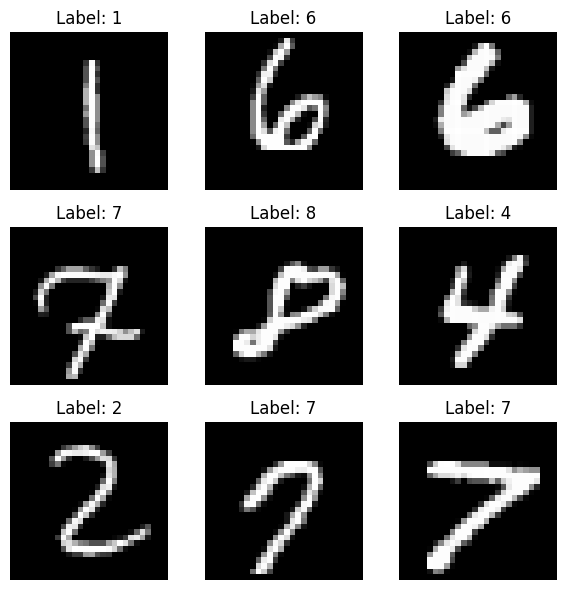

In [ ]:
# Plot the first 9 images from the training set
plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## 4. Model Definition and Compilation

In [7]:
# Convert numpy arrays to torch tensors
tensor_X_train = torch.from_numpy(X_train).unsqueeze(1).to(torch.float32)   # shape (N,1,28,28)
tensor_y_train = torch.from_numpy(y_train).long()
tensor_X_val   = torch.from_numpy(X_val).unsqueeze(1).to(torch.float32)
tensor_y_val   = torch.from_numpy(y_val).long()
tensor_X_test  = torch.from_numpy(x_test).unsqueeze(1).to(torch.float32)
tensor_y_test  = torch.from_numpy(y_test).long()

# Create TensorDatasets
train_dataset = TensorDataset(tensor_X_train, tensor_y_train)
val_dataset   = TensorDataset(tensor_X_val, tensor_y_val)
test_dataset  = TensorDataset(tensor_X_test, tensor_y_test)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the model
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        # input (N,1,28,28)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=0)   # output (32,26,26)
        self.relu1 = nn.ReLU()                                    # using ReLU instead of tanh
        self.pool1 = nn.MaxPool2d(2)                              # output (32,13,13)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=0)  # output (64,11,11)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=0)  # output (64,9,9)
        self.relu3 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)                              # output (64,4,4) -> flatten 64*4*4 = 1024

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 4 * 4, 100)
        self.relu_fc1 = nn.ReLU()
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.pool1(x)
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.relu_fc1(self.fc1(x))
        x = self.fc2(x)
        return x

model = LeNet5().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

## 5. Model Training

In [8]:
n_epochs = 10

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

for epoch in range(1, n_epochs + 1):
    # train 
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == y_batch).sum().item()
        total += X_batch.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # validate
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_running_loss += loss.item() * X_batch.size(0)
            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == y_batch).sum().item()
            val_total += X_batch.size(0)

    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch}/{n_epochs} - train_loss: {train_loss:.4f}, train_acc: {train_acc*100:.2f}%, val_loss: {val_loss:.4f}, val_acc: {val_acc*100:.2f}%")

Epoch 1/10 - train_loss: 0.2517, train_acc: 92.29%, val_loss: 0.0824, val_acc: 97.53%
Epoch 2/10 - train_loss: 0.0665, train_acc: 97.91%, val_loss: 0.0496, val_acc: 98.55%
Epoch 3/10 - train_loss: 0.0445, train_acc: 98.64%, val_loss: 0.0596, val_acc: 98.20%
Epoch 4/10 - train_loss: 0.0354, train_acc: 98.89%, val_loss: 0.0464, val_acc: 98.70%
Epoch 5/10 - train_loss: 0.0282, train_acc: 99.09%, val_loss: 0.0341, val_acc: 98.97%
Epoch 6/10 - train_loss: 0.0227, train_acc: 99.28%, val_loss: 0.0334, val_acc: 99.10%
Epoch 7/10 - train_loss: 0.0188, train_acc: 99.39%, val_loss: 0.0315, val_acc: 99.10%
Epoch 8/10 - train_loss: 0.0161, train_acc: 99.47%, val_loss: 0.0370, val_acc: 98.87%
Epoch 9/10 - train_loss: 0.0128, train_acc: 99.56%, val_loss: 0.0398, val_acc: 98.82%
Epoch 10/10 - train_loss: 0.0114, train_acc: 99.59%, val_loss: 0.0404, val_acc: 98.80%


## 6. Ploting accuracy and loss 

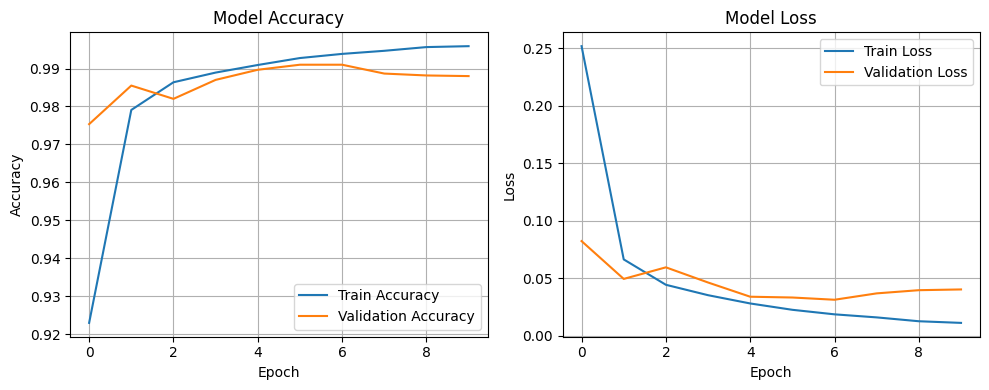

In [9]:
# Plot training history
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 7. Evaluation

In [10]:
# Evaluate on the test set
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1)
        test_correct += (preds == y_batch).sum().item()
        test_total += y_batch.size(0)

test_acc = test_correct / test_total
print(f'Accuracy on test set: {test_acc * 100.0:.3f}%')

Accuracy on test set: 99.030%
